# Chapter 6 Linear Model Selection and Regularization

- Recall the linear model
\begin{equation}Y=\beta_{0}+\beta_{1} X_{1}+\cdots+\beta_{p} X_{p}+\epsilon\end{equation}
- In the lectures that follow, we consider some approaches for extending the linear model framework. In the lectures covering Chapter 7 of the text, we generalize the linear model in order to accommodate non-linear, but still additive, relationships.
- In the lectures covering Chapter 8 we consider even more general non-linear models.
- Despite its simplicity, the linear model has distinct advantages in terms of its interpretability and often shows good predictive performance.
- Hence we discuss in this lecture some ways in which the simple linear model can be improved, by replacing ordinary least squares fitting with some alternative fitting procedures.

### Why consider alternatives to least squares?

- Prediction Accuracy: especially when p > n, to control the variance.
- Model Interpretability: By removing irrelevant features, that is, by setting the corresponding coefficient estimates to zero we can obtain a model that is more easily interpreted. We will present some approaches for automatically performing feature selection.

### Three classes of methods

- Subset Selection. We identify a subset of the p predictors
that we believe to be related to the response. We then fit a
model using least squares on the reduced set of variables.
- Shrinkage. We fit a model involving all p predictors, but
the estimated coefficients are shrunken towards zero
relative to the least squares estimates. This shrinkage (also
known as regularization) has the effect of reducing variance
and can also perform variable selection.
- Dimension Reduction. We project the p predictors into a
M-dimensional subspace, where M < p. This is achieved by
computing M different linear combinations, or projections,
of the variables. Then these M projections are used as
predictors to fit a linear regression model by least squares.

### Subset selection

#### Best Subset Selection
1. Let $\mathcal{M}_{0}$ denote the null model, which contains no predictors. This model simply predicts the sample mean for each observation.
2. For $k=1,2, \ldots p:$
(a) Fit all $\left(\begin{array}{l}p \\ k\end{array}\right)$ models that contain exactly $k$ predictors.
(b) Pick the best among these $\left(\begin{array}{l}p \\ k\end{array}\right)$ models, and call it $\mathcal{M}_{k} .$ Here best is defined as having the smallest RSS, or equivalently largest $R^{2}$.
3. Select a single best model from among $\mathcal{M}_{0}, \ldots, \mathcal{M}_{p}$ using cross-validated prediction error, $C_{p}(\mathrm{AIC}), \mathrm{BIC},$ or adjusted $R^{2}$

In [3]:
# Example - Credit data set
#load modules
import pandas as pd
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.model_selection import train_test_split

In [4]:
#load credit card dataset
credit = pd.read_csv('data/Credit.csv', index_col =0)
credit.dtypes

Limit         int64
Rating        int64
Cards         int64
Age           int64
Education     int64
Gender       object
Student      object
Married      object
Ethnicity    object
Balance       int64
dtype: object

In [5]:
#mark the predictors and respond variables
X= credit.iloc[:, :-1]
y= credit.Balance

In [6]:
#convert the categorical variables
credit_dummies = pd.get_dummies(credit[['Gender', 'Student', 'Married', 'Ethnicity']])
credit =credit.drop(credit[['Gender', 'Student', 'Married', 'Ethnicity']],axis=1)
credit_dummies =credit_dummies.drop(['Gender_Female', 'Student_No', 'Married_No', 'Ethnicity_African American'],axis=1)
credit_df= pd.concat([credit, credit_dummies], axis=1)
credit_df.info

<bound method DataFrame.info of          Limit  Rating  Cards  Age  Education  Balance  Gender_ Male  \
Income                                                                 
14.891    3606     283      2   34         11      333             1   
106.025   6645     483      3   82         15      903             0   
104.593   7075     514      4   71         11      580             1   
148.924   9504     681      3   36         11      964             0   
55.882    4897     357      2   68         16      331             1   
...        ...     ...    ...  ...        ...      ...           ...   
12.096    4100     307      3   32         13      560             1   
13.364    3838     296      5   65         17      480             1   
57.872    4171     321      5   67         12      138             0   
37.728    2525     192      1   44         13        0             1   
18.701    5524     415      5   64          7      966             0   

         Student_Yes  Married_Y

In [7]:
#mark the predictors and respond variables
X= credit_df.loc[:, credit_df.columns != 'Balance']
y= credit_df.Balance

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def fit_ols(X,y):
    ols = LinearRegression()
    ols_model =ols.fit(X,y)
    RSS= round(mean_squared_error(y,ols_model.predict(X)) * len(y),2)
    R_square = round(ols_model.score(X,y),2)
    return RSS, R_square

In [9]:
fit_ols(X,y)

(14617892.35, 0.83)

In [10]:
import itertools

k = 11
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

#Looping over k = 1 to k = 11 features in X
for k in range(1,len(X.columns) + 1):
    #Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(X.columns,k):
        tmp_result = fit_ols(X[list(combo)],y)   #Store temp result b
        RSS_list.append(tmp_result[0])                  #Append lists
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})

In [11]:
df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)

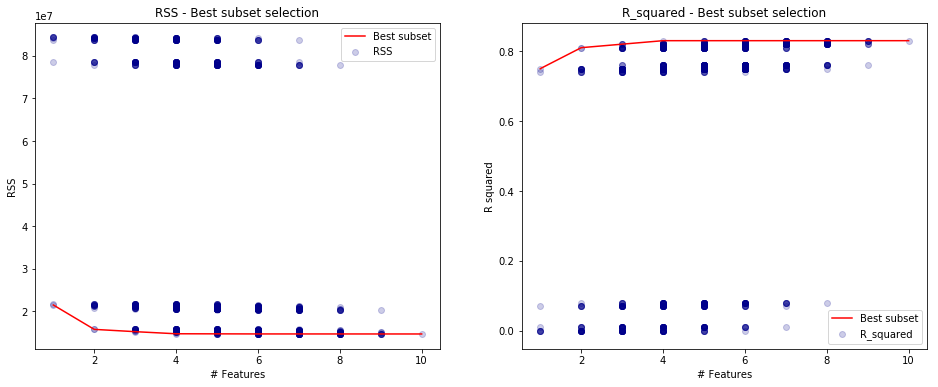

In [12]:
fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(df.numb_features,df.RSS, alpha = .2, color = 'darkblue' )
ax.set_xlabel('# Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.plot(df.numb_features,df.min_RSS,color = 'r', label = 'Best subset')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(df.numb_features,df.R_squared, alpha = .2, color = 'darkblue' )
ax.plot(df.numb_features,df.max_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('R squared')
ax.set_title('R_squared - Best subset selection')
ax.legend()

plt.show()

For each possible model containing a subset of the ten predictors in the Credit data set, the RSS and R2 are displayed. The red frontier tracks the best model for a given number of predictors, according to RSS and R2. Though the data set contains only ten predictors, the x-axis ranges from 1 to 11, since one of the variables is categorical and takes on three values, leading to the creation of two dummy variables.
Although we have presented best subset selection here for least squares regression, the same ideas apply to other types of models, such as logistic regression. The deviance, negative two times the maximized log-likelihood, plays the role of RSS for a broader class of models.

### Stepwise Selection

- For computational reasons, best subset selection cannot be
applied with very large p. Why not?
- Best subset selection may also suffer from statistical
problems when p is large: larger the search space, the
higher the chance of finding models that look good on the
training data, even though they might not have any
predictive power on future data.
- Thus an enormous search space can lead to overfitting and
high variance of the coefficient estimates.
- For both of these reasons, stepwise methods, which explore
a far more restricted set of models, are attractive
alternatives to best subset selection.

### Forward Stepwise Selection
- Forward stepwise selection begins with a model containing
no predictors, and then adds predictors to the model,
one-at-a-time, until all of the predictors are in the model.
- In particular, at each step the variable that gives the
greatest additional improvement to the fit is added to the
model.
1. Let $\mathcal{M}_{0}$ denote the null model, which contains no predictors.
2. For $k=0, \ldots, p-1:$
2.1 Consider all $p-k$ models that augment the predictors in $\mathcal{M}_{k}$ with one additional predictor.
2.2 Choose the best among these $p-k$ models, and call it $\mathcal{M}_{k+1} .$ Here best is defined as having smallest RSS or highest $R^{2}$
3. Select a single best model from among $\mathcal{M}_{0}, \ldots, \mathcal{M}_{p}$ using cross-validated prediction error, $C_{p}(\mathrm{AIC}), \mathrm{BIC},$ or adjusted $R^{2}$.

- Computational advantage over best subset selection is
clear.
- It is not guaranteed to find the best possible model out of
all $2^{p}$ models containing subsets of the p predictors. Why
not? Give an example.

In [13]:
# one variable
ols = LinearRegression()
sfs1 = sfs(ols,
           k_features=1,
           forward=True,
           floating=False,
           verbose=2,
           scoring='neg_mean_squared_error',
           cv=5,
           n_jobs=-1)
sfs1.fit(X, y)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.5s finished

[2020-04-22 16:39:18] Features: 1/1 -- score: -54293.176584293506

SequentialFeatureSelector(clone_estimator=True, cv=5,
                          estimator=LinearRegression(copy_X=True,
                                                     fit_intercept=True,
                                                     n_jobs=None,
                                                     normalize=False),
                          fixed_features=None, floating=False, forward=True,
                          k_features=1, n_jobs=-1, pre_dispatch='2*n_jobs',
                          scoring='neg_mean_squared_error', verbose=2)

In [14]:
# two variables
sfs2 = sfs(ols,
           k_features=2,
           forward=True,
           floating=False,
           verbose=2,
           scoring='neg_mean_squared_error',
           cv=5,
           n_jobs=-1)
sfs2.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[2020-04-22 16:39:20] Features: 1/2 -- score: -54293.176584293506[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.0s finished

[2020-04-22 16:39:20] Features: 2/2 -- score: -40104.361174004574

SequentialFeatureSelector(clone_estimator=True, cv=5,
                          estimator=LinearRegression(copy_X=True,
                                                     fit_intercept=True,
                                                     n_jobs=None,
                                                     normalize=False),
                          fixed_features=None, floating=False, forward=True,
                          k_features=2, n_jobs=-1, pre_dispatch='2*n_jobs',
                          scoring='neg_mean_squared_error', verbose=2)

In [15]:
# three variable
sfs3 = sfs(ols, k_features =3, forward =True, floating =False, verbose= 2, scoring = 'neg_mean_squared_error', cv=5, n_jobs=-1)
sfs3.fit(X,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[2020-04-22 16:39:21] Features: 1/3 -- score: -54293.176584293506[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.0s finished

[2020-04-22 16:39:21] Features: 2/3 -- score: -40104.361174004574[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.0s finished

[2020-04-22 16:39:21] Features: 3/3 -- score: -38706.395570382505

SequentialFeatureSelector(clone_estimator=True, cv=5,
                          estimator=LinearRegression(copy_X=True,
                                                     fit_intercept=True,
                                                     n_jobs=None,
                                                     normalize=False),
                          fixed_features=None, floating=False, forward=True,
                          k_features=3, n_jobs=-1, pre_dispatch='2*n_jobs',
                          scoring='neg_mean_squared_error', verbose=2)

In [16]:
# four variables
sfs4 = sfs(ols, k_features =4, forward =True, floating =False, verbose= 2, scoring = 'neg_mean_squared_error', cv=5, n_jobs=-1)
sfs4.fit(X,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[2020-04-22 16:39:21] Features: 1/4 -- score: -54293.176584293506[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.0s finished

[2020-04-22 16:39:21] Features: 2/4 -- score: -40104.361174004574[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.0s finished

[2020-04-22 16:39:22] Features: 3/4 -- score: -38706.395570382505[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7

SequentialFeatureSelector(clone_estimator=True, cv=5,
                          estimator=LinearRegression(copy_X=True,
                                                     fit_intercept=True,
                                                     n_jobs=None,
                                                     normalize=False),
                          fixed_features=None, floating=False, forward=True,
                          k_features=4, n_jobs=-1, pre_dispatch='2*n_jobs',
                          scoring='neg_mean_squared_error', verbose=2)

In [17]:
dat= [['one variable', sfs1.k_feature_names_],['two variables', sfs2.k_feature_names_], ['three variables', sfs3.k_feature_names_], ['four variables', sfs4.k_feature_names_]]

dat_df = pd.DataFrame(dat, columns=['Number of Variables','Forward stepwise Selection'])

print(dat_df)

  Number of Variables         Forward stepwise Selection
0        one variable                          (Rating,)
1       two variables              (Rating, Student_Yes)
2     three variables         (Rating, Age, Student_Yes)
3      four variables  (Rating, Cards, Age, Student_Yes)


The first four selected models for best subset selection and
forward stepwise selection on the Credit data set. The first
three models are identical but the fourth models differ.

### Backward Subset Selection

- Like forward stepwise selection, backward stepwise selection
provides an efficient alternative to best subset selection.
- However, unlike forward stepwise selection, it begins with
the full least squares model containing all p predictors, and
then iteratively removes the least useful predictor,
one-at-a-time.

1. Let $\mathcal{M}_{p}$ denote the full model, which contains all $p$ predictors.
2. For $k=p, p-1, \ldots, 1:$
2.1 Consider all $k$ models that contain all but one of the predictors in $\mathcal{M}_{k},$ for a total of $k-1$ predictors.
2.2 Choose the best among these $k$ models, and call it $\mathcal{M}_{k-1}$ Here best is defined as having smallest RSS or highest $R^{2}$.
3. Select a single best model from among $\mathcal{M}_{0}, \ldots, \mathcal{M}_{p}$ using cross-validated prediction error, $C_{p}(\mathrm{AIC}), \mathrm{BIC},$ or adjusted $R^{2}$

- Like forward stepwise selection, the backward selection
approach searches through only 1 + p(p + 1)=2 models, and
so can be applied in settings where p is too large to apply
best subset selection
- Like forward stepwise selection, backward stepwise
selection is not guaranteed to yield the best model
containing a subset of the p predictors.
- Backward selection requires that the number of samples n
is larger than the number of variables p (so that the full
model can be fit). In contrast, forward stepwise can be
used even when n < p, and so is the only viable subset
method when p is very large.

### Choosing the optimal model

- The model containing all of the predictors will always have
the smallest RSS and the largest R2, since these quantities
are related to the training error.
- We wish to choose a model with low test error, not a model
with low training error. Recall that training error is usually
a poor estimate of test error.
- Therefore, RSS and R2 are not suitable for selecting the
best model among a collection of models with dierent
numbers of predictors.

### Estimating test error: two approaches

- We can indirectly estimate test error by making an
adjustment to the training error to account for the bias due
to overfitting.
- We can directly estimate the test error, using either a
validation set approach or a cross-validation approach, as
discussed in previous lectures.

#### Adjusting training error

- These techniques adjust the training error for the model
size, and can be used to select among a set of models with
different numbers of variables.
- The next figures displays Cp, BIC, and adjusted R2 for the
best model of each size produced by best subset selection
on the Credit data set.

#### Mallow's $C_{p}$ :
$$
C_{p}=\frac{1}{n}\left(\mathrm{RSS}+2 d \hat{\sigma}^{2}\right)
$$
where $d$ is the total # of parameters used and $\hat{\sigma}^{2}$ is an estimate of the variance of the error $\epsilon$ associated with each response measurement.
- The $A I C$ criterion is defined for a large class of models fit by maximum likelihood:
$$
\mathrm{AIC}=-2 \log L+2 \cdot d
$$
where $L$ is the maximized value of the likelihood function for the estimated model.
: In the case of the linear model with Gaussian errors, maximum likelihood and least squares are the same thing, and $C_{p}$ and AIC are equivalent.

#### BIC
$$
\mathrm{BIC}=\frac{1}{n}\left(\mathrm{RSS}+\log (n) d \hat{\sigma}^{2}\right)
$$
- Like $C_{p},$ the BIC will tend to take on a small value for a model with a low test error, and so generally we select the model that has the lowest BIC value.
" Notice that BIC replaces the $2 d \hat{\sigma}^{2}$ used by $C_{p}$ with a $\log (n) d \hat{\sigma}^{2}$ term, where $n$ is the number of observations.
- since $\log n>2$ for any $n>7,$ the BIC statistic generally places a heavier penalty on models with many variables, and hence results in the selection of smaller models than $C_{p} .$ See Figure on slide 19

#### Adjusted $R^{2}$
- For a least squares model with $d$ variables, the adjusted $R^{2}$ statistic is calculated as
$$
\text { Adjusted } R^{2}=1-\frac{\mathrm{RSS} /(n-d-1)}{\operatorname{TSS} /(n-1)}
$$
where TSS is the total sum of squares.
\bullet Unlike $C_{p}, \mathrm{AIC},$ and $\mathrm{BIC},$ for which a small value indicates a model with a low test error, a large value of adjusted $R^{2}$ indicates a model with a small test error.
- Maximizing the adjusted $R^{2}$ is equivalent to minimizing $\frac{\mathrm{RSS}}{n-d-1} \cdot$ While RSS always decreases as the number of variables in the model increases, $\frac{\mathrm{RSS}}{n-d-1}$ may increase or decrease, due to the presence of $d$ in the denominator.
- Unlike the $R^{2}$ statistic, the adjusted $R^{2}$ statistic pays $a$ price for the inclusion of unnecessary variables in the model.

#### Validation and Cross-Validation
。 Each of the procedures returns a sequence of models $\mathcal{M}_{k}$ indexed by model size $k=0,1,2, \ldots . .$ Our job here is to select $\hat{k} .$ Once selected, we will return model $\mathcal{M}_{\hat{k}}$
・ We compute the validation set error or the cross-validation error for each model $\mathcal{M}_{k}$ under consideration, and then select the $k$ for which the resulting estimated test error is smallest.
- This procedure has an advantage relative to AIC, BIC, $C_{p}$ and adjusted $R^{2},$ in that it provides a direct estimate of the test error, and doesn't require an estimate of the error variance $\sigma^{2}$
It can also be used in a wider range of model selection tasks, even in cases where it is hard to pinpoint the model degrees of freedom (e.g. the number of predictors in the model) or hard to estimate the error variance $\sigma^{2}$

#### Ridge regression and Lasso
- The subset selection methods use least squares to fit a
linear model that contains a subset of the predictors.
- As an alternative, we can fit a model containing all p
predictors using a technique that constrains or regularizes
the coefficient estimates, or equivalently, that shrinks the
coefficient estimates towards zero.
- It may not be immediately obvious why such a constraint
should improve the fit, but it turns out that shrinking the
coefficient estimates can significantly reduce their variance.

#### Ridge Regression
。 Recall that the least squares fitting procedure estimates $\beta_{0}, \beta_{1}, \ldots, \beta_{p}$ using the values that minimize
$$
\mathrm{RSS}=\sum_{i=1}^{n}\left(y_{i}-\beta_{0}-\sum_{j=1}^{p} \beta_{j} x_{i j}\right)^{2}
$$
In contrast, the ridge regression coefficient estimates $\hat{\beta}^{R}$ are the values that minimize
$\sum_{i=1}^{n}\left(y_{i}-\beta_{0}-\sum_{j=1}^{p} \beta_{j} x_{i j}\right)^{2}+\lambda \sum_{j=1}^{p} \beta_{j}^{2}=\mathrm{RSS}+\lambda \sum_{j=1}^{p} \beta_{j}^{2}$
where $\lambda \geq 0$ is a tuning parameter, to be determined separately.
- As with least squares, ridge regression seeks coefficient
estimates that fit the data well, by making the RSS small.
- However, the second term, $\lambda \sum_{j=1}^{p}$, called a shrinkage
penalty, is small when $\beta_{0}, \beta_{1}, \ldots, \beta_{p}$ are close to zero, and so it
has the effect of shrinking the estimates of $\beta_{j}$ towards zero.
- The tuning parameter $\lambda$ serves to control the relative
impact of these two terms on the regression coefficient
estimates.
- Selecting a good value for $\lambda$ is critical; cross-validation is
used for this.

In [18]:
# Credit Card Example
import pandas as pd
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale, StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

import itertools
from itertools import combinations

%matplotlib inline
plt.style.use('seaborn-white') 

In [19]:
df_credit = pd.read_csv('Data/Credit.csv', index_col=0)
df_credit["Gender"] = df_credit["Gender"].astype('category')
df_credit["Student"] = df_credit["Student"].astype('category')
df_credit["Married"] = df_credit["Married"].astype('category')
df_credit["Ethnicity"] = df_credit["Ethnicity"].astype('category')
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 400 entries, 14.890999999999998 to 18.701
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Limit      400 non-null    int64   
 1   Rating     400 non-null    int64   
 2   Cards      400 non-null    int64   
 3   Age        400 non-null    int64   
 4   Education  400 non-null    int64   
 5   Gender     400 non-null    category
 6   Student    400 non-null    category
 7   Married    400 non-null    category
 8   Ethnicity  400 non-null    category
 9   Balance    400 non-null    int64   
dtypes: category(4), int64(6)
memory usage: 23.8 KB


In [20]:
y = df_credit.Balance

X = df_credit[df_credit.columns.difference(['Balance'])]
# Use K-1 columns for K categories so Yes/No uses only one column 0/1
X = pd.get_dummies(X, drop_first=True)
X_scaled = scale(X)
X.head(3)

,Age,Cards,Education,Limit,Rating,Ethnicity_Asian,Ethnicity_Caucasian,Gender_Female,Married_Yes,Student_Yes
Income,,,,,,,,,,
14.891,34,2,11,3606,283,0,1,0,1,0
106.025,82,3,15,6645,483,1,0,1,1,1
104.593,71,4,11,7075,514,1,0,0,0,0


In [21]:
n_lambdas = 200
lambdas = np.logspace(5, -2, n_lambdas)

coefs = []
scores = []
for lam in lambdas:
    ridge = Ridge(alpha=lam)
    # it's very important to scale the data for Ridge regression
    ridge.fit(X_scaled, y)
    coefs.append(ridge.coef_)
    scores.append(ridge.score(X_scaled, y))

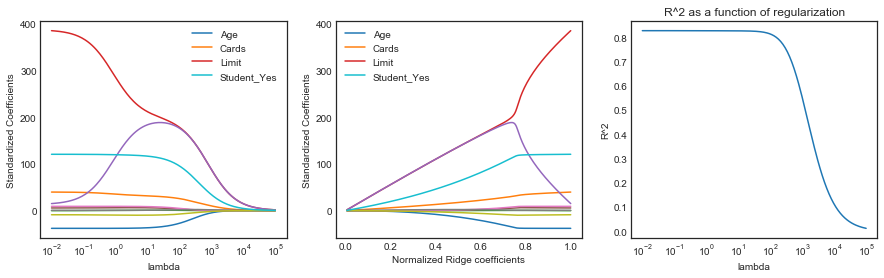

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))

# get the four largest (in abs value) coefficient positions
ind = np.argpartition(np.abs(coefs[-1]), -4)[-4:]

# firt plot
ax1.plot(lambdas, coefs)
ax1.set_xscale('log')
ax1.set_xlabel('lambda')
ax1.set_ylabel('Standardized Coefficients')
ax1.legend(np.array(ax1.get_lines())[ind], X.columns[ind]);

# second plot
no_ridge_norm = linalg.norm(coefs[-1])
norm_coefs = linalg.norm(coefs/no_ridge_norm, axis=1)
ax2.plot(norm_coefs, coefs)
ax2.set_xlabel('Normalized Ridge coefficients')
ax2.set_ylabel('Standardized Coefficients')
ax2.legend(np.array(ax2.get_lines())[ind], X.columns[ind]); #delimiter

# third
ax3.plot(lambdas, scores)
ax3.set_xscale('log')
ax3.set_xlabel('lambda')
ax3.set_ylabel('R^2')
ax3.set_title('R^2 as a function of regularization');


- In the left-hand panel, each curve corresponds to the ridge regression coefficient estimate for one of the ten variables, plotted as a function of $\lambda$
- The right-hand panel displays the same ridge coefficient estimates as the left-hand panel, but instead of displaying $\lambda$ on the $x$ -axis, we now display $\left\|\hat{\beta}_{\lambda}^{R}\right\|_{2} /\|\hat{\beta}\|_{2},$ where $\hat{\beta}$ denotes the vector of least squares coefficient estimates.
- The notation $\|\beta\|_{2}$ denotes the $\ell_{2}$ norm (pronounced "ell $\left.2^{\prime \prime}\right)$ of a vector, and is defined as $\|\beta\|_{2}=\sqrt{\sum_{j=1}^{p} \beta_{j}^{2}}$

#### Scaling of predictors

- The standard least squares coefficient estimates are scale equivariant: multiplying $X_{j}$ by a constant $c$ simply leads to a scaling of the least squares coefficient estimates by a factor of $1 / c .$ In other words, regardless of how the $j$ th predictor is scaled, $X_{j} \hat{\beta}_{j}$ will remain the same.
In contrast, the ridge regression coefficient estimates can change substantially when multiplying a given predictor by a constant, due to the sum of squared coefficients term in the penalty part of the ridge regression objective function.
- Therefore, it is best to apply ridge regression after standardizing the predictors, using the formula
$$
\tilde{x}_{i j}=\frac{x_{i j}}{\sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(x_{i j}-\bar{x}_{j}\right)^{2}}}
$$

### Lasso
- Ridge regression does have one obvious disadvantage:
unlike subset selection, which will generally select models that involve just a subset of the variables, ridge regression will include all $p$ predictors in the final model
- The Lasso is a relatively recent alternative to ridge regression that overcomes this disadvantage. The lasso coefficients, $\hat{\beta}_{\lambda}^{L},$ minimize the quantity
$\sum_{i=1}^{n}\left(y_{i}-\beta_{0}-\sum_{j=1}^{p} \beta_{j} x_{i j}\right)^{2}+\lambda \sum_{j=1}^{p}\left|\beta_{j}\right|=\mathrm{RSS}+\lambda \sum_{j=1}^{p}\left|\beta_{j}\right|$
- In statistical parlance, the lasso uses an $\ell_{1}$ (pronounced
"ell 1") penalty instead of an $\ell_{2}$ penalty. The $\ell_{1}$ norm of a coefficient vector $\beta$ is given by $\|\beta\|_{1}=\sum\left|\beta_{j}\right|$
- As with ridge regression, the lasso shrinks the coefficient
estimates towards zero.
- However, in the case of the lasso, the $l_{1}$ penalty has the
efect of forcing some of the coefficient estimates to be
exactly equal to zero when the tuning parameter $\lambda$ is
sufficiently large.
- Hence, much like best subset selection, the lasso performs
variable selection.
- We say that the lasso yields sparse models | that is,
models that involve only a subset of the variables.
- As in ridge regression, selecting a good value of $\lambda$ for the
lasso is critical; cross-validation is again the method of
choice.

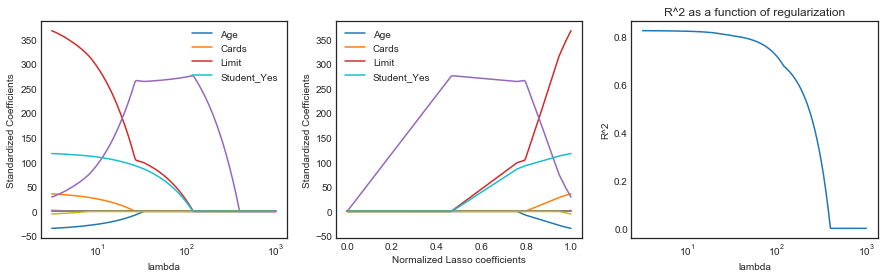

In [24]:
n_lambdas = 200
lambdas = np.logspace(3, 0.5, n_lambdas)

coefs = []
scores = []
for lam in lambdas:
    lasso = Lasso(alpha=lam)
    lasso.fit(X_scaled, y)
    coefs.append(lasso.coef_)
    scores.append(lasso.score(X_scaled, y));
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))

# get the four largest (in abs value) coefficient positions
ind = np.argpartition(np.abs(coefs[-1]), -4)[-4:]

# firt plot
ax1.plot(lambdas, coefs)
ax1.set_xscale('log')
ax1.set_xlabel('lambda')
ax1.set_ylabel('Standardized Coefficients')
ax1.legend(np.array(ax1.get_lines())[ind], X.columns[ind]);

# second plot
no_lasso_norm = linalg.norm(coefs[-1], ord=1)
norm_coefs = linalg.norm(coefs/no_lasso_norm, axis=1, ord=1)
ax2.plot(norm_coefs, coefs)
ax2.set_xlabel('Normalized Lasso coefficients')
ax2.set_ylabel('Standardized Coefficients')
ax2.legend(np.array(ax2.get_lines())[ind], X.columns[ind]);

# third
ax3.plot(lambdas, scores)
ax3.set_xscale('log')
ax3.set_xlabel('lambda')
ax3.set_ylabel('R^2')
ax3.set_title('R^2 as a function of regularization');

# the values for lambda are different here than in the text
# most likely the function that is minimized is a bit different in scikit-learn and R
# there's probably a factor of N or 2N (N=len(y)) difference.

Why is it that the lasso, unlike ridge regression, results in coefficient estimates that are exactly equal to zero?

One can show that the lasso and ridge regression coefficient estimates solve the problems
$$
\underset{\beta}{\operatorname{minimize}} \sum_{i=1}^{n}\left(y_{i}-\beta_{0}-\sum_{j=1}^{p} \beta_{j} x_{i j}\right)^{2} \quad \text { subject to } \quad \sum_{j=1}^{p}\left|\beta_{j}\right| \leq s
$$
and
$$
\underset{\beta}{\operatorname{minimize}} \sum_{i=1}^{n}\left(y_{i}-\beta_{0}-\sum_{j=1}^{p} \beta_{j} x_{i j}\right)^{2} \quad \text { subject to } \quad \sum_{j=1}^{p} \beta_{j}^{2} \leq s
$$
respectively.

![ridge and lasso](images/ridge.png)

#### Conclusions
- These two examples illustrate that neither ridge regression
nor the lasso will universally dominate the other.
- In general, one might expect the lasso to perform better
when the response is a function of only a relatively small
number of predictors.
- However, the number of predictors that is related to the
response is never known a priori for real data sets.
- A technique such as cross-validation can be used in order
to determine which approach is better on a particular data
set.

#### Selecting the Tuning Parameter for Ridge Regression and Lasso
- As for subset selection, for ridge regression and lasso we
require a method to determine which of the models under
consideration is best.
- That is, we require a method selecting a value for the
tuning parameter $\lambda$ or equivalently, the value of the
constraint s.
- Cross-validation provides a simple way to tackle this
problem. We choose a grid of $\lambda$ values, and compute the
cross-validation error rate for each value of $\lambda$.
- We then select the tuning parameter value for which the
cross-validation error is smallest.
- Finally, the model is re-fit using all of the available
observations and the selected value of the tuning
parameter.

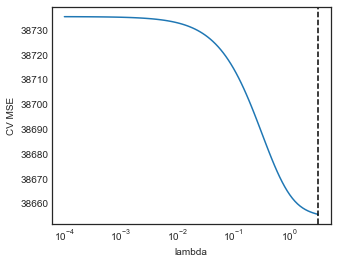

In [29]:
lambdas = np.logspace(0.5, -4, 100)
ridgeCV = RidgeCV(alphas=lambdas, store_cv_values=True)
ridgeCV.fit(X_scaled, y)
MSE_alphas = np.mean(ridgeCV.cv_values_, axis=0)

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.plot(lambdas, MSE_alphas)
ax.axvline(ridgeCV.alpha_, color='k', linestyle='--')
ax.set_xscale('log')
ax.set_xlabel('lambda')
ax.set_ylabel('CV MSE');

#### Dimension Reduction Methods
- The methods that we have discussed so far in this chapter
have involved fitting linear regression models, via least
squares or a shrunken approach, using the original
predictors, $X_{0}, X_{1}, \ldots, X_{p}$.
- We now explore a class of approaches that transform the
predictors and then fit a least squares model using the
transformed variables. We will refer to these techniques as
dimension reduction methods.

#### Dimension Reduction Methods: details
- Let $Z_{1}, Z_{2}, \ldots, Z_{M}$ represent $M<p$ linear combinations of our original $p$ predictors. That is,
$Z_{m}=\sum_{j=1}^{p} \phi_{m j} X_{j}$
for some constants $\phi_{m 1}, \ldots, \phi_{m p}$
- We can then fit the linear regression model,
$$
y_{i}=\theta_{0}+\sum_{m=1}^{M} \theta_{m} z_{i m}+\epsilon_{i}, \quad i=1, \ldots, n
$$
using ordinary least squares.
- Note that in model (2), the regression coefficients are given by $\theta_{0}, \theta_{1}, \ldots, \theta_{M} .$ If the constants $\phi_{m 1}, \ldots, \phi_{m p}$ are chosen wisely, then such dimension reduction approaches can often outperform OLS regression

- Notice that from definition (1),
$\sum_{m=1}^{M} \theta_{m} z_{i m}=\sum_{m=1}^{M} \theta_{m} \sum_{j=1}^{p} \phi_{m j} x_{i j}=\sum_{j=1}^{p} \sum_{m=1}^{M} \theta_{m} \phi_{m j} x_{i j}=\sum_{j=1}^{p} \beta_{j} x_{i j}$
where $\beta_{j}=\sum_{m=1}^{M} \theta_{m} \phi_{m j}$
- Hence model (2) can be thought of as a special case of the original linear regression model.
- Dimension reduction serves to constrain the estimated $\beta_{j}$ coefficients, since now they must take the form (3)
- Can win in the bias-variance tradeoff.

#### Principal Components Regression
- Here we apply principal components analysis (PCA)
(discussed in Chapter 10 of the text) to define the linear
combinations of the predictors, for use in our regression.
- The first principal component is that (normalized) linear
combination of the variables with the largest variance.
- The second principal component has largest variance,
subject to being uncorrelated with the first.
- Hence with many correlated original variables, we replace
them with a small set of principal components that capture
their joint variation.

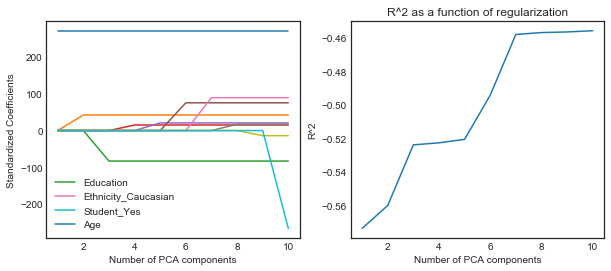

In [33]:
components = list(range(1, X_scaled.shape[1]+1))
coefs = []
scores = []
for comp in components:
    pca = PCA(n_components=comp)
    X_pca_comp = pca.fit_transform(X_scaled)
    # use the first comp components
    #X_pca_comp = X_pca[:, 0:comp+1]
    linear = LinearRegression(fit_intercept=False)
    linear.fit(X_pca_comp, y)
    coefs.append(linear.coef_)
    scores.append(linear.score(X_pca_comp, y));
    
coefs = np.array(list(itertools.zip_longest(*coefs, fillvalue=0))).T

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# get the four largest (in abs value) coefficient positions
ind = np.argpartition(np.abs(coefs[-1]), -4)[-4:]

# firt plot
ax1.plot(components, coefs)
ax1.set_xlabel('Number of PCA components')
ax1.set_ylabel('Standardized Coefficients')
ax1.legend(np.array(ax1.get_lines())[ind], X.columns[ind])

# third
ax2.plot(components, scores)
ax2.set_xlabel('Number of PCA components')
ax2.set_ylabel('R^2')
ax2.set_title('R^2 as a function of regularization');


#### Partial Least Squares
- PCR identifies linear combinations, or directions, that best
represent the predictors $X_{0}, X_{1}, \ldots, X_{p}$.
- These directions are identified in an unsupervised way, since
the response Y is not used to help determine the principal
component directions.
- That is, the response does not supervise the identification
of the principal components.
- Consequently, PCR suffers from a potentially serious
drawback: there is no guarantee that the directions that
best explain the predictors will also be the best directions
to use for predicting the response. 
- Like PCR, PLS is a dimension reduction method, which
first identifies a new set of features $Z_{0}, Z_{1}, \ldots, Z_{p}$ that are
linear combinations of the original features, and then fits a
linear model via OLS using these M new features.
- But unlike PCR, PLS identifies these new features in a
supervised way - that is, it makes use of the response Y in
order to identify new features that not only approximate
the old features well, but also that are related to the
response.
- Roughly speaking, the PLS approach attempts to find
directions that help explain both the response and the
predictors.
- After standardizing the $p$ predictors, PLS computes the first direction $Z_{1}$ by setting each $\phi_{1 j}$ in (1) equal to the coefficient from the simple linear regression of $Y$ onto $X_{j}$
one can show that this coefficient is proportional to the correlation between $Y$ and $X_{j}$
- Hence, in computing $Z_{1}=\sum_{j=1}^{p} \phi_{1 j} X_{j},$ PLS places the highest weight on the variables that are most strongly related to the response.
- Subsequent directions are found by taking residuals and then repeating the above prescription.

### Summary
- Model selection methods are an essential tool for data
analysis, especially for big datasets involving many
predictors.
- Research into methods that give sparsity, such as the lasso
is an especially hot area.
- Later, we will return to sparsity in more detail, and will
describe related approaches such as the elastic net.

### End of Chapter 6

In [34]:
# Exercise Problems